In [587]:
from __future__ import annotations
import networkx as nx
import matplotlib.pyplot as plt
from celluloid import Camera
from dataclasses import dataclass
from typing import Union, Self, Callable, List
from random import randint, choice
from math import inf
from queue import PriorityQueue

In [588]:
GRAPH_SEED: int = 1
DRAWING_SEED: int = 1
DIRECTED_GRAPH: bool = False
GRAPH_SIZE: int = 8
EDGE_PROBABILITY: float = 0.33

In [589]:
class Graph:
    def __init__(self, g: Union[nx.Graph, None]=None) -> None:
        if g is None:
            self.g: nx.Graph = nx.Graph()
        else:
            self.g: nx.Graph = g

    @classmethod
    def create_example_graph(cls: type[Graph]) -> Graph:
        g = nx.erdos_renyi_graph(GRAPH_SIZE, EDGE_PROBABILITY, seed=GRAPH_SEED, directed=DIRECTED_GRAPH)
        for (u, v) in g.edges():
            g.edges[u,v]['weight'] = randint(1,10)
            try:
                g.edges[v,u]['weight'] = g.edges[u,v]['weight']
            except KeyError:
                pass
        return cls(g)

    @dataclass
    class FunctionOutput:
        visited: list
        parents: dict
        
        def __repr__(self) -> str:
            return "".join([f"{parent} -> {node}\n" for node, parent in self.parents.items()])
    
    @staticmethod
    def bfs(g: nx.Graph, start: int) -> Graph.FunctionOutput:
        queue: list = [start]
        visited: list = [start]
        parents: dict = {}
        while queue:
            print(f"Queue: {queue}")
            node: int = queue.pop(0)
            print(f"Current node: {node}")
            for neighbour in g.neighbors(node):
                if neighbour not in visited:
                    visited.append(neighbour)
                    parents[neighbour] = node
                    queue.append(neighbour)
        return Graph.FunctionOutput(visited, parents)
    

    @staticmethod
    def dfs(g: nx.Graph, start: int) -> Graph.FunctionOutput:
        visited = []
        parents = {}
        Graph.dfs_recursion(g, start, visited, parents)
        print(visited)
        print(parents)
        return Graph.FunctionOutput(visited, parents)
    
    @staticmethod
    def dfs_recursion(g: nx.Graph, start: int, visited: list, parents: dict) -> Graph.FunctionOutput:
        visited.append(start)
        print(f"Visited: {visited}")
        print(f"Current node: {start}")
        for node in g.neighbors(start):
            if node not in visited:
                parents[node] = start
                Graph.dfs_recursion(g, node, visited, parents)
    
    @staticmethod
    def cost(g, node1, node2) -> float:
        return g.get_edge_data(node1,node2).get('weight')
    
    @staticmethod
    def djikstra(g: nx.Graph, start: int):
        prev = {v: -1 for v in g.nodes()}
        dist = {v: inf for v in g.nodes()}
        dist[start] = 0
        pq = PriorityQueue()
        for node, value in dist.items():
            pq.put((value, node))
        while not pq.empty():
            _, node = pq.get()
            for neighbour in g.neighbors(node):
                if neighbour in [x[1] for x in pq.queue]:
                    path = dist[node] + Graph.cost(g, node, neighbour)
                    if path < dist[neighbour]:
                        print(f"Found new path to {neighbour} with cost {path}")
                        pq.queue.remove((dist[neighbour],neighbour))
                        dist[neighbour] = path
                        prev[neighbour] = node
                        pq.put((path, neighbour))
        for key in dist.keys():
            print(f"for {key}, cost: {dist[key]} from {prev[key]}")

    @staticmethod
    def get_edges(g: nx.Graph, node: int, mst) -> list[tuple[int, float]]:
        return list((n2 if n1==node else n1, g.edges()[n1,n2]["weight"]) for n1, n2 in g.edges(node) if not (n2 in mst and n1 in mst))

    @staticmethod
    def find_min_edge(edges) -> tuple[int, float]:
        min_edge = (None, inf)
        for edge in edges:
            if edge[1] < min_edge[1]:
                min_edge = edge
        return min_edge

    @staticmethod
    def prim(g: nx.Graph, start: int) -> None:
        mst = list()
        edges = Graph.get_edges(g, start, mst)
        mst.append(start)
        while len(mst) < len(g.nodes()):
            min_edge, min_weight = Graph.find_min_edge(edges)
            mst.append(min_edge)
            edges += Graph. get_edges(g, min_edge, mst)
            edges.remove((min_edge, min_weight))
        print(mst)


    
    def draw(self: Self, node_colors: Union[List[str], None]=None) -> None:
        node_colors = node_colors or ['white' for node in self.g.nodes()]
        elarge = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] > 0.5]
        esmall = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] <= 0.5]
        #pos = nx.spring_layout(self.g, seed=DRAWING_SEED)
        pos = nx.shell_layout(self.g)
        nx.draw_networkx_nodes(self.g, pos, node_size=700, node_color=node_colors)
        nx.draw_networkx_edges(self.g, pos, edgelist=elarge, width=3)
        nx.draw_networkx_edges(
            self.g, pos, edgelist=esmall, width=3, alpha=0.5, edge_color="b", style="dashed"
        )
        nx.draw_networkx_labels(self.g, pos, font_size=20, font_family="sans-serif")
        edge_labels = nx.get_edge_attributes(self.g, "weight")
        nx.draw_networkx_edge_labels(self.g, pos, edge_labels)
        ax = plt.gca()
        ax.margins(0.08)
        plt.axis("off")
        plt.tight_layout()
        
    def draw_function(self: Self, start: int, function_to_draw: Callable [[nx.Graph, int], Graph.FunctionOutput]) -> None:
            fig = plt.figure()
            camera = Camera(fig)
            self.plots = []
            function_ouput = function_to_draw(self.g, start)
            print(f"Path:\n{function_ouput}")
            tmp = []
            for i in function_ouput.visited:
                tmp.append(i)
                colors = ['r' if node in tmp else 'white' for node in self.g.nodes() ]
                self.draw(node_colors=colors)
                camera.snap()
            camera.animate().save(f'{function_to_draw.__name__}.gif', writer='imagemagick', fps=1)
    
    

In [590]:
graph = Graph.create_example_graph()

Queue: [0]
Current node: 0
Queue: [1, 4]
Current node: 1
Queue: [4, 3]
Current node: 4
Queue: [3, 7]
Current node: 3
Queue: [7, 2, 5, 6]
Current node: 7
Queue: [2, 5, 6]
Current node: 2
Queue: [5, 6]
Current node: 5
Queue: [6]
Current node: 6
Path:
0 -> 1
0 -> 4
1 -> 3
4 -> 7
3 -> 2
3 -> 5
3 -> 6



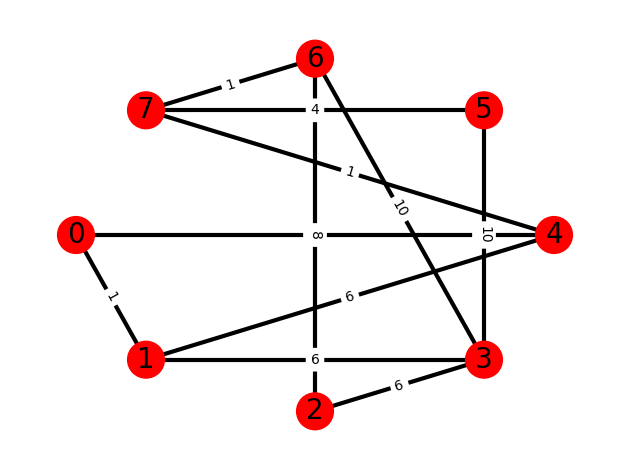

In [591]:
graph.draw_function(0, Graph.bfs)

Visited: [0]
Current node: 0
Visited: [0, 1]
Current node: 1
Visited: [0, 1, 3]
Current node: 3
Visited: [0, 1, 3, 2]
Current node: 2
Visited: [0, 1, 3, 2, 6]
Current node: 6
Visited: [0, 1, 3, 2, 6, 7]
Current node: 7
Visited: [0, 1, 3, 2, 6, 7, 4]
Current node: 4
Visited: [0, 1, 3, 2, 6, 7, 4, 5]
Current node: 5
[0, 1, 3, 2, 6, 7, 4, 5]
{1: 0, 3: 1, 2: 3, 6: 2, 7: 6, 4: 7, 5: 7}
Path:
0 -> 1
1 -> 3
3 -> 2
2 -> 6
6 -> 7
7 -> 4
7 -> 5



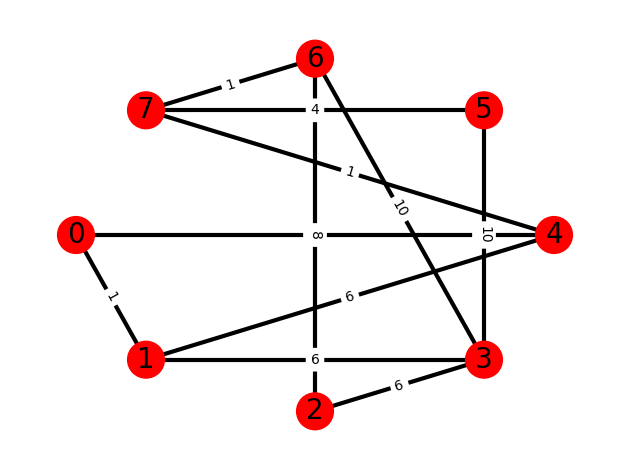

In [592]:
graph.draw_function(0, Graph.dfs)

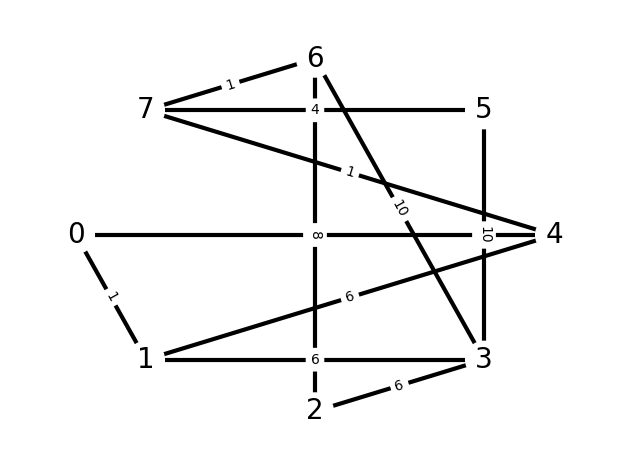

In [593]:
graph.draw()

In [594]:
Graph.djikstra(graph.g, 0)

Found new path to 1 with cost 1
Found new path to 4 with cost 4
Found new path to 3 with cost 7
Found new path to 7 with cost 5
Found new path to 5 with cost 9
Found new path to 6 with cost 6
Found new path to 2 with cost 14
Found new path to 2 with cost 13
for 0, cost: 0 from -1
for 1, cost: 1 from 0
for 2, cost: 13 from 3
for 3, cost: 7 from 1
for 4, cost: 4 from 0
for 5, cost: 9 from 7
for 6, cost: 6 from 7
for 7, cost: 5 from 4


In [595]:
edges = Graph.prim(graph.g, 0)

[0, 1, 4, 7, 6, 5, 3, 4]


In [596]:
edges